In [1]:
using Catlab
using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using Catlab.Programs
using Catlab.Graphics

using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using AlgebraicDynamics.UWDDynam
using AlgebraicDynamics.CPortGraphDynam
using AlgebraicDynamics.CPortGraphDynam: grid

using LabelledArrays

using DynamicalSystems, OrdinaryDiffEq
using Plots

In [239]:
using Catlab.Graphics: Graphviz

function save_graphviz(filename::AbstractString, g; format::String="svg")
  open(filename, "w") do io
    Graphviz.run_graphviz(io, g, format=format)
  end
end

save_graphviz (generic function with 1 method)

# Ecosystem

In [183]:
eco_pattern = @relation (rabbits, foxes, hawks, fish) begin
    land_eco(rabbits, foxes, hawks)
    river_eco(fish, hawks)
end

gv = to_graphviz(eco_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75"))

save_graphviz("eco_tot_pattern.svg", gv) # hide


In [184]:
rabbitfox_pattern = @relation (rabbits, foxes) begin
    growth(rabbits)
    predation(rabbits, foxes)
    decline(foxes)
end

rabbithawk_pattern = @relation (rabbits, hawks) begin
    growth(rabbits)
    predation(rabbits, hawks)
    decline(hawks)
end

# Define the composition pattern for rabbit growth
rabbit_pattern = @relation (rabbits,) -> growth(rabbits)

# Define transformations between the composition patterns
rabbitfox_transform  = ACSetTransformation((Box=[1], Junction=[1], Port=[1], OuterPort=[1]), rabbit_pattern, rabbitfox_pattern)
rabbithawk_transform = ACSetTransformation((Box=[1], Junction=[1], Port=[1], OuterPort=[1]), rabbit_pattern, rabbithawk_pattern)

# Take the pushout
land_pattern = ob(pushout(rabbitfox_transform, rabbithawk_transform))

gv = to_graphviz(land_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75"))
save_graphviz("eco_land_pattern.svg", gv) # hide


In [130]:
predation(species) =  (u,p,t) -> [-p[Symbol(:β, first(species), last(species))], p[Symbol(:γ, first(species), last(species))]]*u[1]*u[2]
growth(species) = (u,p,t) -> p[Symbol(:α, first(species))]*u
decline(species) = (u,p,t) -> -p[Symbol(:δ, first(species))]*u

get_models(pattern) = map(parts(pattern, :Box)) do i
    interaction_type = subpart(pattern, i, :name)
    species = subpart(pattern, incident(land_pattern, i, :box), [:junction, :variable])
    nspecies = length(species)
    ex = Expr(:call, interaction_type, species)
    ContinuousResourceSharer{Float64}(nspecies, nspecies,
        (u,p,t) -> eval(ex)(u,p,t),
        1:nspecies)
end

primitive_land_models = get_models(land_pattern)

# Compose
land_sys= oapply(land_pattern, primitive_land_models)

ContinuousResourceSharer(ℝ^3 → ℝ^3) with 3 exposed ports

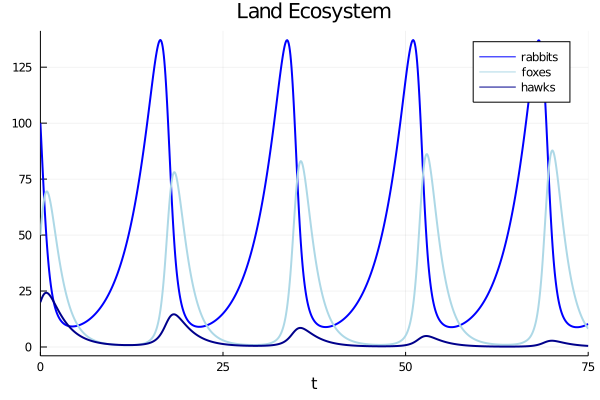

In [192]:
params = LVector(αrabbits = 0.3, βrabbitsfoxes = 0.015, γrabbitsfoxes = 0.015, δfoxes = 0.7,
    βrabbitshawks = 0.01, γrabbitshawks = 0.01, δhawks = 0.5,
    αfish = 0.35, βfishhawks = 0.003, γfishhawks = 0.001)

tspan = (0.0, 75.0)
u0 = [100.0, 50.0, 20.0]
prob = ODEProblem(land_sys, u0, tspan, params)

sol = solve(prob, Tsit5())
plot(sol, lw = 2, title = "Land Ecosystem", label = ["rabbits" "foxes" "hawks"], color = [:blue :lightblue :darkblue])

In [185]:
river_pattern = @relation (fish, hawks) begin
    growth(fish)
    predation(fish, hawks)
end

river_sys = oapply(river_pattern, get_models(river_pattern))

gv = to_graphviz(river_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75"))
save_graphviz("eco_river_pattern.svg", gv) # hide


In [238]:
eco_sys = oapply(eco_pattern, [land_sys, river_sys])

params = LVector(αrabbits = 0.3, βrabbitsfoxes = 0.015, γrabbitsfoxes = 0.03, δfoxes = 0.7,
    βrabbitshawks = 0.01, γrabbitshawks = 0.005, δhawks = 0.5,
    αfish = 0.35, βfishhawks = 0.02, γfishhawks = 0.01)

tspan = (0.0, 100.0)
u0 = [100.0, 50.0, 20.0, 100.0]
prob = ODEProblem(eco_sys, u0, tspan, params)

sol = solve(prob, Tsit5())
plot(sol, lw = 2, title = "Ecosystem", label = ["rabbits" "foxes" "hawks" "fish"])
savefig("eco_solution.pdf")

In [237]:
big_pattern = ocompose(eco_pattern, [land_pattern, river_pattern])
gv = to_graphviz(big_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75"))
save_graphviz("eco_big_pattern.pdf", gv) # hide

In [383]:
eval_dynamics(river_models[2], [100.0, 20], params, 0)

2-element Array{Float64,1}:
 -30.0
  30.0

In [379]:
eval(primitive_land_models[1])([1], [], 0)

LoadError: MethodError: objects of type ContinuousResourceSharer{Float64} are not callable

# SIR

In [235]:
ncities = 3
roads = [1=>2, 2=> 3]
nout_roads = map(i -> count(r -> r.first == i, roads), 1:ncities)

3-element Array{Int64,1}:
 1
 1
 0

In [236]:
city_pattern = WiringDiagram([], [])
cities = map(1:ncities) do i
    add_box!(city_pattern, Box(Symbol("city", i), [:S, :I, :R], [:S, :I, :R]))
end

wires = map(Base.Iterators.product(roads, 1:3)) do ((src, tgt), j)
    add_wire!(city_pattern, (cities[src], j) => (cities[tgt], j))
end

gv = to_graphviz(city_pattern)
save_graphviz("sir_pattern1.pdf", gv) # hide


In [150]:
city_models = map(1:ncities) do i
    ContinuousMachine{Float64}(3,3,3,
    (u,x,p,t) -> p.μ*(x - nout_roads[i]*u) + [
            -p[Symbol("β",i)]*u[1]*u[2],  # Ṡ
            p[Symbol("β",i)]*u[1]*u[2] - p[Symbol("γ",i)]*u[2],  # İ
            p[Symbol("γ",i)]*u[2] ],  # Ṙ
    u -> u)
end

sir_model = oapply(city_pattern, city_models)

ContinuousMachine(ℝ^9 × ℝ^0 → ℝ^9)

In [224]:
params = LVector(μ = 0.01,
    β1 = 0.7, γ1 = 0.4,
    β2 = 0.4, γ2 = 0.4,
    β3 = 0.1, γ3 = 0.4
)

u0 = [100.0, 1.0, 0, 100.0, 0, 0, 100.0, 0, 0]
tspan = (0.0, 2.0)

prob = ODEProblem(sir_model, u0, tspan, params)
sol = solve(prob, Tsit5(); dtmax = 0.01)

plot(sol, lw = 2, title = "SIR Model",
    label = ["city 1 - S" "city 1 - I" "city 1 - R" "city 2 - S" "city 2 - I" "city 2 - R" "city 3 - S" "city 3 - I" "city 3 - R"],
    color = [:lightblue :blue  :darkblue  :lightpink :hotpink :deeppink  :palegreen :mediumseagreen :green]
)

savefig("sir_solution.pdf")

# Heat map

`u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]`

In [100]:
W = 10; H = 20

stencil = OpenCPortGraph()
boxes = reshape(add_parts!(stencil, :Box, W*H), H, W)

ports = map(i -> add_parts!(stencil, :Port, 4,  box = i), boxes)

# add up/downarrows
map(view(boxes, 1:(H - 1), 1:W)) do b
    add_part!(stencil, :Wire, src = ports[b][3], tgt = ports[b + 1][1])
    add_part!(stencil, :Wire, tgt = ports[b][3], src = ports[b + 1][1])
end
#add left/right arrows
map(view(boxes, 1:H, 1:(W-1))) do b
    add_part!(stencil, :Wire, src = ports[b][2], tgt = ports[b+H][4])
    add_part!(stencil, :Wire, tgt = ports[b][2], src = ports[b+H][4])
end

# add outer ports
add_parts!(stencil, :OuterPort, W, con = map(i -> ports[1,i][1], 1:W))
add_parts!(stencil, :OuterPort, W, con = map(i -> ports[H,i][3], 1:W))
add_parts!(stencil, :OuterPort, H, con = map(i -> ports[i,1][4], 1:H))
add_parts!(stencil, :OuterPort, H, con = map(i -> ports[i,W][2], 1:H))

print()

In [101]:
point_model = DiscreteMachine{Float64}(4, 1, 4, 
    (u,x,p,t) -> [p.γ * (sum(x) - 4*u[1]) + u[1]],
    u -> repeat(u, 4)
)

heat_eq = oapply(stencil, point_model)

DiscreteMachine(ℝ^200 × ℝ^60 → ℝ^200)

In [246]:
u0 = zeros(Float64, W*H)
xs = 100*vcat(ones(W), zeros(W), zeros(H), zeros(H))

alpha = 2
delta_x = 1

delta_t = (delta_x ^ 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ^ 2)


params = LVector(γ = gamma)

traj = trajectory(heat_eq, u0, xs, params, 1000)

200-dimensional Dataset{Float64} with 1001 points
  0.0      0.0      0.0      …  0.0       0.0       0.0       0.0
 25.0      0.0      0.0         0.0       0.0       0.0       0.0
 31.25     6.25     0.0         0.0       0.0       0.0       0.0
 35.9375   9.375    1.5625      0.0       0.0       0.0       0.0
 38.2812  12.5      2.73438     0.0       0.0       0.0       0.0
 40.2344  14.4531   4.19922  …  0.0       0.0       0.0       0.0
 41.4551  16.2842   5.29785     0.0       0.0       0.0       0.0
 42.5232  17.5659   6.45142     0.0       0.0       0.0       0.0
 43.2709  18.7622   7.34863     0.0       0.0       0.0       0.0
 43.9438  19.6594   8.24585     0.0       0.0       0.0       0.0
 44.4485  20.5006   8.96683  …  0.0       0.0       0.0       0.0
 44.9111  21.1615   9.67493     0.0       0.0       0.0       0.0
 45.2746  21.7845  10.2591      0.0       0.0       0.0       0.0
  ⋮                          ⋱                                
 49.1264  28.539   18.5146   

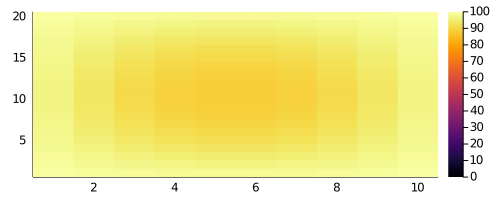

In [243]:
t = 100

Plots.heatmap(reshape(traj[t], (H, W)), clim = (0, 100.0))
plot!(size=(W*50,H*10))
#plot!(size=(W*50,H*10))

# savefig("heat_60.png")

In [247]:
ts = [2, 11, 21, 31, 41]

#plot(hms..., layout = (4,4), colorbar = false)


hms = map(ts) do t 
    heatmap(reshape(traj[t], (H, W)), clim = (0, 100.0))
end


plot(hms..., layout = (1,5), colorbar = false, 
       title = ["t = 1" "t = 10" "t = 20" "t = 30" "t = 40"], titlefont = font(8))
plot!(size=(W*50,H*10))
plot!(xticks = false)
plot!(yticks = false)

savefig("heat_bot.svg")